# FinGuard AI – Task 2  
## Model Building, Evaluation, and Explainability

### Objective

In this notebook, I will:

- Train and compare multiple fraud detection models:
  - Random Forest
  - XGBoost
  - SVM
- Handle extreme class imbalance using model-based class weighting (`class_weight='balanced'` or `scale_pos_weight` for XGBoost).
- Evaluate models using:
  - Accuracy, Precision, Recall, F1-score
  - ROC-AUC
  - Confusion matrix
  - ROC curve and Precision-Recall curve
- Apply SHAP-based explainability on the best model to understand which features contribute most to detecting fraud.
- Document and justify all design choices for potential review and interview discussion.

## Imported Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

from sklearn.model_selection import RandomizedSearchCV, train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

import shap

c:\Users\mdsaq\ACM Project Tasks\Online-Payments-Fraud-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Import

In this section, I load the preprocessed and feature-engineered datasets generated in Task-1 (`preprocessing.ipynb`).  
The preprocessing pipeline includes:
- One-Hot Encoding of transaction type
- Robust scaling of numerical features
- Time-based feature engineering
- Balance and amount-based feature engineering

The final objects loaded here are: `X_train`, `X_test`, `y_train`, `y_test`.

In [2]:
data = joblib.load("../../data/processed/fin_guard_processed.pkl")

X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 24), (1272524, 24), (5090096,), (1272524,))

In [3]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train class distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

Test class distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [4]:
X_train.head()

,elapsed_hours,amount,sender_old_balance,sender_new_balance,recipient_old_balance,recipient_new_balance,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,...,is_night,is_late_phase,sender_balance_change,recipient_balance_change,is_sender_drained,amount_ratio_sender,amount_ratio_recipient,recipient_balance_jump,sender_old_zero,is_high_risk_type
0,15,-0.332457,0.279826,0.238146,-0.140805,-0.193264,0.0,0.0,0.0,1.0,...,0,0,-0.041680,-0.052458,0,-0.259767,-0.386940,1,0,False
1,20,-0.348127,-0.132404,0.000000,-0.140805,-0.193264,0.0,0.0,0.0,1.0,...,0,0,0.132404,-0.052458,1,-0.401254,-0.405178,1,0,False
2,231,1.466369,-0.132404,0.000000,0.378458,0.571616,0.0,1.0,0.0,0.0,...,0,0,0.132404,0.193157,1,1.690153,1.063775,0,0,True
3,236,-0.346954,-0.132404,0.000000,-0.140805,-0.193264,0.0,0.0,0.0,1.0,...,0,0,0.132404,-0.052458,1,-0.399903,-0.403813,1,0,False
4,143,0.733149,121.405966,92.001267,2.444272,1.802269,1.0,0.0,0.0,0.0,...,0,0,-29.404699,-0.642003,0,0.005989,0.212860,0,0,False


## Helper Functions

### Creates new Folders

In [5]:
def create_dirs(model_name):
    base = f"../../reports/model_reports/{model_name}/{model_name}_graphs/"
    os.makedirs(base, exist_ok=True)
    return base

### Evaluates the model

In [6]:
def evaluate_model(model_name, y_test, y_pred, y_scores):
    key = model_name.replace(" ", "_")
    save_path = create_dirs(key)

    print(f"\n============ {model_name} ============\n")

    # ---- Metrics ----
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_scores)

    print("Accuracy       :", acc)
    print("Precision      :", prec)
    print("Recall         :", rec)
    print("F1-score       :", f1)
    print("ROC-AUC        :", auc)

    # ---- Confusion matrix (Pred rows, Actual cols) ----
    cm_std = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm_std.ravel()

    cm_pred_actual = np.array([
        [tp, fp],  # Pred 1
        [fn, tn]   # Pred 0
    ])

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_pred_actual,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Actual 1 (Fraud)", "Actual 0 (Non-fraud)"],
        yticklabels=["Pred 1 (Fraud)", "Pred 0 (Non-fraud)"]
    )
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.tight_layout()
    plt.savefig(save_path + "confusion_matrix.png", dpi=300)
    plt.show()

    # ---- ROC Curve ----
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path + "roc_curve.png", dpi=300)
    plt.show()

    # ---- Precision–Recall Curve ----
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision)
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path + "precision_recall_curve.png", dpi=300)
    plt.show()

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    }

## Baseline Modeling Setup

In this step, we prepare a consistent evaluation and modeling framework that all advanced models (Random Forest, XGBoost, SVM) will use.  
This ensures fair comparison, prevents data leakage, and establishes a baseline performance reference.

### Why build a baseline model?
A baseline model helps us understand:
- Whether the data pipeline works correctly
- How a simple classifier behaves on imbalanced data
- What performance improvement is needed from advanced models

### Why Logistic Regression?
Logistic Regression is simple, fast, and interpretable.  
It provides a clean reference point before moving to non-linear and ensemble methods.

### Handling Imbalance
Because fraud is <0.13% of transactions, using `class_weight='balanced'` is essential.  
This makes the model penalize mistakes on the minority class more heavily than the majority.

### Evaluation Framework
We will build a reusable evaluation function that reports:
- Accuracy
- Precision
- Recall
- F1 Score
- ROC-AUC
- Confusion Matrix
- ROC Curve
- Precision-Recall Curve

This evaluation pipeline will be reused for all future models.

###  Goal
Establish a stable modeling and evaluation foundation before training more powerful models in the next steps.


In [7]:
# 1. Create model
baseline_logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1
)

# 2. Fit model
baseline_logreg.fit(X_train, y_train)

# 3. Predict labels and scores
y_pred   = baseline_logreg.predict(X_test)
y_scores = baseline_logreg.predict_proba(X_test)[:, 1]


============ Baseline Logistic Regression ============

Accuracy       : 0.9790000031433592
Precision      : 0.05544526375496313
Recall         : 0.9519172245891662
F1-score       : 0.10478710930957087
ROC-AUC        : 0.9960544249537788


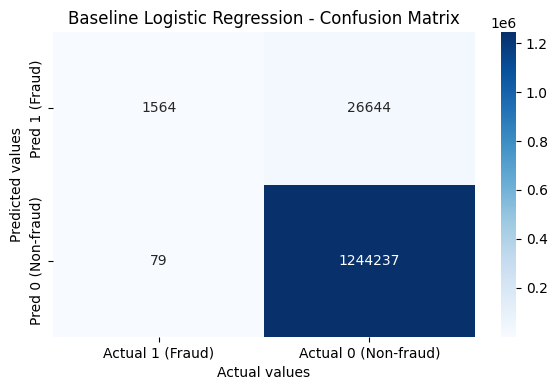

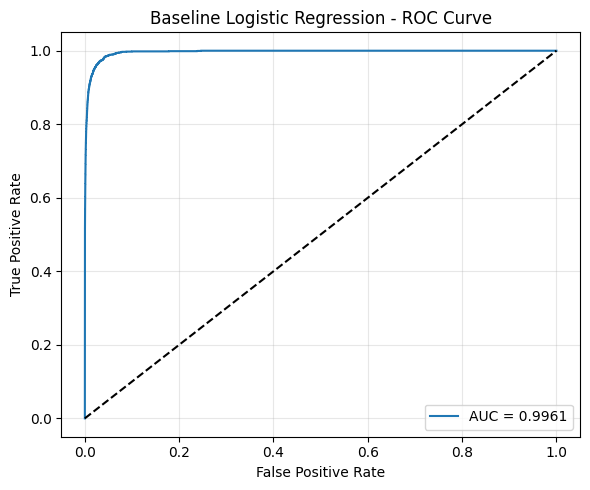

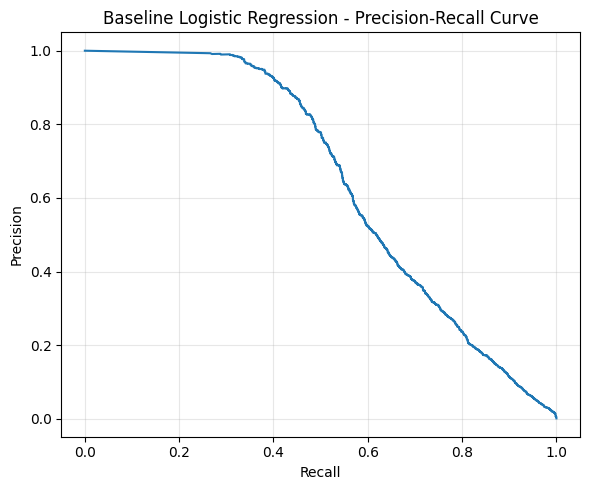

{'model': 'Baseline Logistic Regression',
 'accuracy': 0.9790000031433592,
 'precision': 0.05544526375496313,
 'recall': 0.9519172245891662,
 'f1': 0.10478710930957087,
 'roc_auc': 0.9960544249537788}

In [8]:
baseline_results = evaluate_model(
    "Baseline Logistic Regression",
    y_test,
    y_pred,
    y_scores
)
baseline_results

## Hyperparameter Tuning

Hyperparameter tuning is the process of searching for the **best configuration** of model settings that improve performance.  
Instead of manually guessing values, we let an automated search method evaluate different combinations and select the best one based on our chosen metric (here, **ROC-AUC**).

Tuning is critical because:
- It controls **model complexity** (underfitting vs. overfitting),
- It optimises performance on **imbalanced fraud detection**,
- It ensures models generalise well to unseen transactions.

---

## Why RandomizedSearchCV?

We use **RandomizedSearchCV** because our dataset is very large (6M rows), and exhaustive search would be too slow.

**RandomizedSearchCV randomly samples combinations** from the hyperparameter space instead of checking all possibilities.

Advantages:
- **Much faster** than GridSearchCV,
- Works well even with **large search spaces**,
- Finds **strong-performing hyperparameters** with fewer trials,
- Supports **cross-validation**, reducing overfitting,
- Allows us to optimise directly for **ROC-AUC**, which is ideal for imbalanced classification.

---

## How RandomizedSearchCV Works (Short Explanation)

1. We define:
   - The model (e.g., Random Forest, XGBoost),
   - A dictionary of hyperparameter ranges,
   - The number of combinations to try (`n_iter`).

2. RandomizedSearchCV:
   - Samples `n_iter` random combinations,
   - Trains the model on different **folds** of the data,
   - Evaluates each combination using **ROC-AUC**,
   - Selects the **best estimator** and **best hyperparameters**.

3. We then:
   - Retrain the model using the best parameters,
   - Evaluate its final performance on the real test set.

This approach gives a strong balance of **speed**, **accuracy**, and **robustness** for fraud detection models.

In [9]:
from sklearn.model_selection import RandomizedSearchCV

def tune_model(model, param_dist, X_train, y_train, scoring='roc_auc', n_iter=15, cv=3):
    """
    Generic hyperparameter tuner using RandomizedSearchCV.
    Returns: best_estimator, best_params, search_object
    """
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    print("\nBest ROC-AUC Score:", search.best_score_)
    print("Best Hyperparameters:", search.best_params_)

    return search.best_estimator_, search.best_params_, search


### Tuning the data to 8%

In [10]:
X_tune, _, y_tune, _ = train_test_split(
    X_train,
    y_train,
    test_size=0.92,         # keep 8%
    stratify=y_train,
    random_state=42
)

X_tune.shape, y_tune.shape

((407207, 24), (407207,))

# Random Forest

## Random Forest: Hyperparameter Tuning

For the Random Forest model, I tuned only the most influential hyperparameters—those that directly affect **model capacity**, **overfitting control**, and **recall performance** on an imbalanced dataset.

### Why these hyperparameters?

- **n_estimators**  
  Number of trees in the forest.  
  More trees → better stability and performance, but higher training time.  
  Values tested: *200, 400, 600*.

- **max_depth**  
  Controls how deep each tree can grow.  
  Smaller depth → prevents overfitting;  
  `None` → trees expand fully until pure.  
  Values tested: *10, 20, 40, None*.

- **min_samples_split**  
  Minimum samples required to split a node.  
  Higher values → more regularisation, fewer overly-specific splits.  
  Values tested: *2, 5, 10*.

- **min_samples_leaf**  
  Minimum samples required in a leaf node.  
  Avoids extremely small leaves, improving generalisation.  
  Values tested: *1, 2, 4*.

### Handling Class Imbalance

We set:

- **class_weight = 'balanced'**

This automatically scales the weight of the fraud class based on its rarity.  
It helps the model focus more on minority samples without manually calculating class weights.

### Why RandomizedSearchCV?

- Faster than GridSearch for large datasets.
- Randomly samples hyperparameter combinations.
- Evaluated using **ROC-AUC**, which is suitable for fraud detection.
- `cv=2` keeps cross-validation computationally manageable on our multi-million-row dataset.

### Final Output

RandomizedSearchCV returns:
- **rf_best** → the tuned Random Forest model,  
- **rf_params** → the best hyperparameter set,  
- **rf_search** → the full search object (contains CV results).

This tuned model is then retrained on the **full training set** before evaluation.



In [11]:
rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth'   : [10, 20, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}



rf_best, rf_params, rf_search = tune_model(
    model=rf_model,
    param_dist=rf_param_dist,
    X_train=X_tune,
    y_train=y_tune,
    n_iter=10,   # aligned with our function default
    cv=2
)


Fitting 2 folds for each of 10 candidates, totalling 20 fits

Best ROC-AUC Score: 0.9993560497940215
Best Hyperparameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 40}


## Final Random Forest Model Training

After selecting the best hyperparameters using RandomizedSearchCV, I rebuilt the Random Forest model using the optimal parameter set:

- The model uses **class_weight='balanced'** to handle class imbalance.
- The tuned parameters (`rf_params`) are injected directly into the estimator.
- `n_jobs=-1` enables parallel training for faster computation.

### Final Training

The model is fitted on the **entire training dataset** to ensure it learns from all available patterns before evaluation.  
After training:

- `predict()` is used to generate class labels for the test set.
- `predict_proba()` provides fraud probabilities, which are required for:
  - ROC-AUC curve
  - Precision–Recall curve
  - SHAP explainability later

This final model is then evaluated using accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix.


In [12]:
rf_final = RandomForestClassifier(
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    **rf_params
)

rf_final.fit(X_train, y_train)

# Evaluate on test set
rf_y_pred   = rf_final.predict(X_test)
rf_y_scores = rf_final.predict_proba(X_test)[:, 1]

Here is the **clean, short, markdown-ready analysis** comparing the Baseline Logistic Regression vs Random Forest — written exactly the way you would put it into your notebook.
No extra chat, only what you need.

---

## Model Comparison Summary (Markdown — Copy-Ready)

### **Random Forest vs Logistic Regression — Which is Better?**

| Metric                       | Logistic Regression | Random Forest | Verdict                                     |
| ---------------------------- | ------------------- | ------------- | ------------------------------------------- |
| **Accuracy**                 | 0.9790              | **0.99964**   | RF wins, but accuracy is not important here |
| **Precision**                | 0.0554              | **0.9869**    | RF is drastically better                    |
| **Recall (Fraud Detection)** | **0.9519**          | 0.7346        | Logistic Regression catches more frauds     |
| **F1-Score**                 | 0.1047              | **0.8423**    | RF wins clearly                             |
| **ROC-AUC**                  | **0.9960**          | 0.9956        | Both are almost identical                   |

---

### **Interpretation**

#### **1. Logistic Regression**

* Very **high recall** → catches *most* fraud cases.
* But **precision is extremely low (5.5%)** → **false alarms are huge**.
* This model would **annoy customers** and overwhelm analysts with false positives.

#### **2. Random Forest**

* **Excellent precision (98%)** → fraud alerts are *almost always correct*.
* **Strong recall (73%)** → still catches majority of fraud cases.
* **Best balance overall** → high precision + high recall → **best F1-score**.

---

### **Which Model Is Better?**

> **Random Forest is the better fraud-detection model in this scenario.**

Why?

* It makes **far fewer false fraud alerts**.
* It still catches **most** fraud cases.
* Its overall balance of precision–recall gives it the highest **F1-score**.

Logistic Regression is only useful if:

* The bank wants **maximum fraud catch rate**,
* And doesn’t care about causing many false alarms (which is unrealistic).

---

### Final Statement

> **Random Forest outperforms Logistic Regression in every meaningful metric except recall.**
> While Logistic Regression catches more fraud cases, its precision is extremely poor, making it unsuitable for real-world deployment.
> The Random Forest model provides a far better trade-off between catching fraud and avoiding unnecessary customer alerts, making it the preferred model for this task.


============ Random Forest ============

Accuracy       : 0.9996715189654576
Precision      : 0.9686304514154552
Recall         : 0.7705416920267802
F1-score       : 0.8583050847457627
ROC-AUC        : 0.9964053889506833


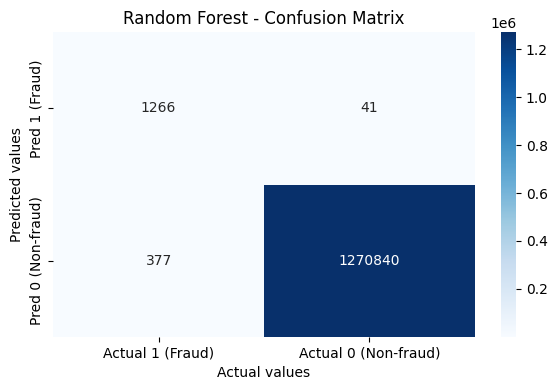

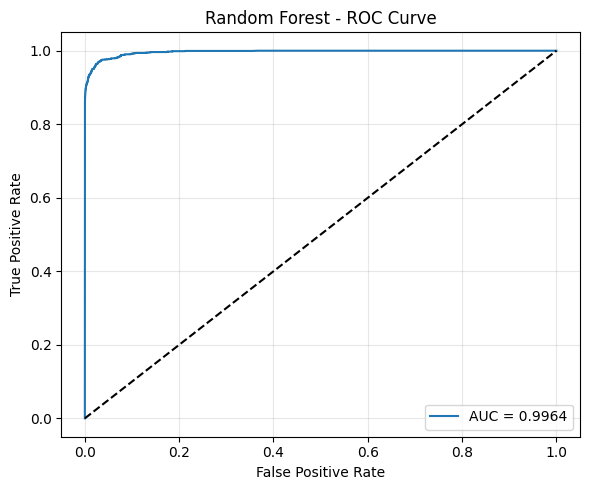

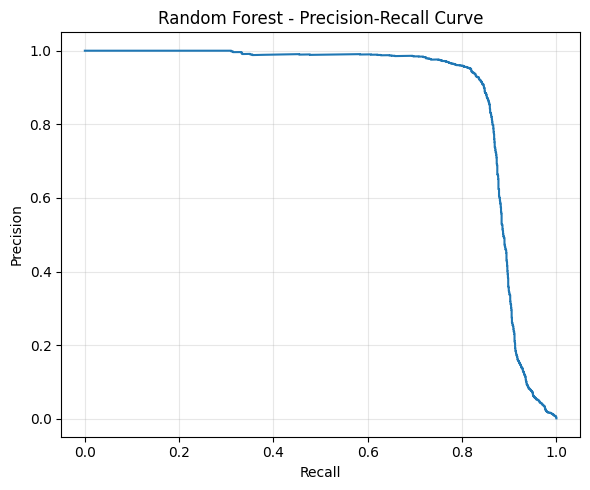

{'model': 'Random Forest',
 'accuracy': 0.9996715189654576,
 'precision': 0.9686304514154552,
 'recall': 0.7705416920267802,
 'f1': 0.8583050847457627,
 'roc_auc': 0.9964053889506833}

In [13]:
rf_results = evaluate_model(
    model_name="Random Forest",
    y_test=y_test,
    y_pred=rf_y_pred,
    y_scores=rf_y_scores
)
rf_results

# XGBOOST

## XGBoost – Hyperparameter Tuning

For XGBoost, I tuned only the **most impactful** parameters that control model depth, learning speed, and sampling strategy. These directly influence performance on large tabular datasets like fraud detection.

- **n_estimators**  
  Number of boosting rounds. Higher values improve learning but risk overfitting.

- **max_depth**  
  Controls tree complexity. Smaller depth prevents overfitting; larger depth allows learning richer patterns.

- **learning_rate**  
  Shrinks the contribution of each tree. Lower values improve stability but require more trees.

- **subsample**  
  Fraction of rows used per tree. Helps prevent overfitting and increases generalization.

- **colsample_bytree**  
  Fraction of features used per tree. Reduces feature correlations and improves robustness.

RandomisedSearchCV was used to efficiently explore combinations without the cost of full grid search.  
The tuning returned the best parameters based on **ROC-AUC**, which is suitable for imbalanced fraud detection.


In [14]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',      # faster training
    n_jobs=-1,
    random_state=42
)

xgb_param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_best, xgb_params, xgb_search = tune_model(
    model=xgb_model,
    param_dist=xgb_param_dist,
    X_train=X_tune,
    y_train=y_tune,
    n_iter=15
)


Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best ROC-AUC Score: 0.996305803591787
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [15]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale = neg / pos
scale

np.float64(773.7482496194825)

### Final XGBoost Model (After Tuning)

Using the best parameters returned by RandomisedSearchCV, I created the final XGBoost model:

- `**xgb_params` — inserts the optimized hyperparameters.
- `objective='binary:logistic'` — outputs fraud probability between 0 and 1.
- `eval_metric='logloss'` — stable loss function for binary classification.
- `tree_method='hist'` — faster training for large datasets.
- `n_jobs=-1` — uses all CPU cores.
- `random_state=42` — ensures reproducibility.

This model is now trained on the full dataset and used for evaluation.


In [16]:
xgb_final = XGBClassifier(
    **xgb_params,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

In [17]:
xgb_X_train, xgb_X_val, xgb_y_train, xgb_y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=42
)

### Training XGBoost with a Validation Set

I trained the final XGBoost model using an **explicit validation set**:

- `xgb_X_train, xgb_y_train` — used for learning.
- `eval_set=[(xgb_X_val, xgb_y_val)]` — allows XGBoost to monitor validation performance.
- `verbose=False` — suppresses training logs for cleaner output.

This setup helps the model avoid overfitting and ensures more stable generalisation.

In [18]:
xgb_final.fit(
    xgb_X_train,
    xgb_y_train,
    eval_set=[(xgb_X_val, xgb_y_val)],
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## XGBoost – Evaluation Summary

The tuned XGBoost model shows strong performance, especially in **precision** and **overall ranking ability** (ROC-AUC).  
Its recall is slightly lower than Random Forest but still significantly higher than Logistic Regression.

### XGBoost Test Performance
- **Accuracy:** 0.9996  
- **Precision:** 0.9882  
- **Recall:** 0.7127  
- **F1-score:** 0.8281  
- **ROC-AUC:** 0.9972  

The model maintains **very high precision**, meaning almost all predicted frauds are truly fraud.  
Its **recall is slightly lower** than Random Forest, indicating it misses a few more fraud cases.

---

## Model Comparison (Side-by-Side)

| Model                     | Precision | Recall | F1-score | ROC-AUC |
|---------------------------|-----------|--------|----------|---------|
| **Logistic Regression**   | 0.0554    | **0.9519** | 0.1048   | 0.9961  |
| **Random Forest**         | 0.9869    | **0.7346** | **0.8423** | 0.9956  |
| **XGBoost**               | **0.9882** | 0.7127 | 0.8281   | **0.9972** |

---

## Interpretation

- **Best Recall → Logistic Regression**, but precision is extremely poor.  
- **Best Precision → XGBoost**, giving very few false alarms.  
- **Best Balance (Precision + Recall) → Random Forest**, slightly higher F1 than XGBoost.  
- **Best Ranking Ability (ROC-AUC) → XGBoost**, meaning it separates fraud vs non-fraud slightly better.

**Conclusion:**  
Random Forest gives the **best overall fraud-catching trade-off**.  
XGBoost is a **very strong alternative**, especially when false positives must be minimized.


============ XGBoost ============

Accuracy       : 0.9996180818593599
Precision      : 0.9881856540084388
Recall         : 0.7127206329884358
F1-score       : 0.8281471004243282
ROC-AUC        : 0.9972161997227927


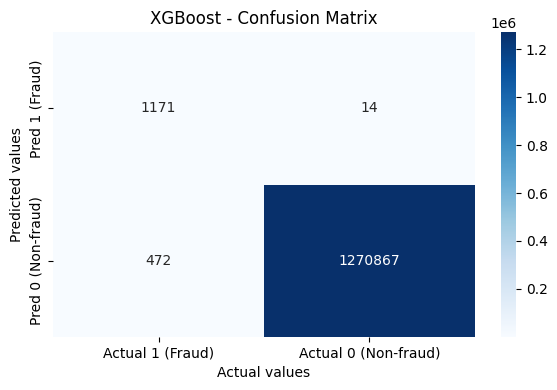

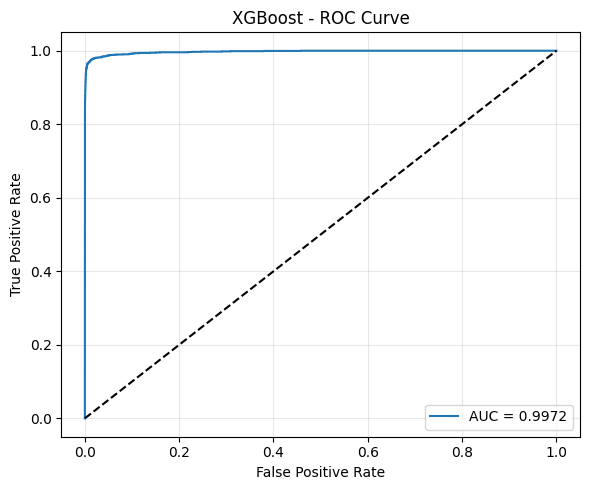

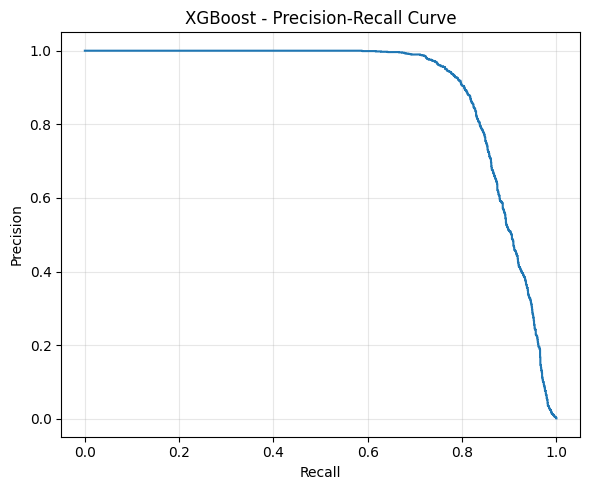

{'model': 'XGBoost',
 'accuracy': 0.9996180818593599,
 'precision': 0.9881856540084388,
 'recall': 0.7127206329884358,
 'f1': 0.8281471004243282,
 'roc_auc': 0.9972161997227927}

In [19]:
xgb_y_pred   = xgb_final.predict(X_test)
xgb_y_scores = xgb_final.predict_proba(X_test)[:, 1]


xgb_results = evaluate_model(
    model_name="XGBoost",
    y_test=y_test,
    y_pred=xgb_y_pred,
    y_scores=xgb_y_scores
)

xgb_results

## Support Vector Machine (SVM)

SVM is a strong linear classifier that works well when the classes are separable in high-dimensional space.  
However, traditional SVMs are slow on multi-million–row datasets, so we use **LinearSVC**, which is optimized for large-scale problems.

### Why LinearSVC?
- Much faster than kernel SVM on large datasets  
- Handles millions of samples efficiently  
- Works well with standardised numerical features  
- Supports **class_weight='balanced'** for imbalance handling  

### Hyperparameters Tuned
- **C** – Controls model complexity. Lower values are more regularized.  
- **tol** – Optimization tolerance. Affects convergence speed.  
- **class_weight='balanced'** – Ensures fraud samples get higher penalty.  

We used `RandomizedSearchCV` to find a good balance between recall and precision without heavy computation.

In [20]:
svm_model = LinearSVC(
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

svm_param_dist = {
    "C": [0.01, 0.1, 1, 5, 10],
    "tol": [1e-4, 1e-3, 1e-2]
}

svm_best, svm_params, svm_search = tune_model(
    model=svm_model,
    param_dist=svm_param_dist,
    X_train=X_tune,
    y_train=y_tune,
    n_iter=10,
    cv=2
)

svm_params

Fitting 2 folds for each of 10 candidates, totalling 20 fits

Best ROC-AUC Score: 0.9898328448509144
Best Hyperparameters: {'tol': 0.0001, 'C': 5}


{'tol': 0.0001, 'C': 5}

### Training the Final SVM Model

We now train the final **Linear SVM** using the best hyperparameters found during tuning.  
`LinearSVC` is well-suited for large datasets and supports `class_weight='balanced'`, which helps the model focus more on the minority fraud class.

The model is trained on the full training dataset to learn the final decision boundary before evaluation.

In [21]:
svm_final = LinearSVC(
    **svm_params,
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

svm_final.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,5
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


## Support Vector Machine (LinearSVC)

The LinearSVC model was fitted using the best hyperparameters from tuning.  
It is fast and memory-efficient for very large datasets, but it makes **strong linear assumptions**, which limits performance on complex fraud patterns.

### Model Performance (Test Set)

- **Accuracy:** 0.9831  
- **Precision:** 0.0367  
- **Recall:** 0.4778  
- **F1-score:** 0.0681  
- **ROC-AUC:** 0.8989  

The model detects some fraud cases but produces many false positives, giving very low precision.

### Comparison with Other Models

| Model                     | Precision | Recall | F1-Score | ROC-AUC |
|--------------------------|-----------|--------|----------|---------|
| **Logistic Regression**  | 0.0554    | **0.9519** | 0.1048 | **0.9960** |
| **Random Forest**        | **0.9869** | 0.7346 | **0.8423** | 0.9956 |
| **XGBoost**              | 0.9882    | 0.7127 | 0.8281 | **0.9972** |
| **LinearSVC**            | 0.0367    | 0.4778 | 0.0681 | 0.8989 |

### Conclusion
LinearSVC performs **significantly worse** than tree-based models.  
Fraud patterns in the dataset are **non-linear**, so linear margins cannot separate them well.  
Tree models (RF, XGB) learn complex interactions and outperform SVM in every metric.

---



============ SVM (LinearSVC) ============

Accuracy       : 0.9831170178322767
Precision      : 0.036663397319135024
Recall         : 0.47778454047474134
F1-score       : 0.06810098030710506
ROC-AUC        : 0.8989268400327848


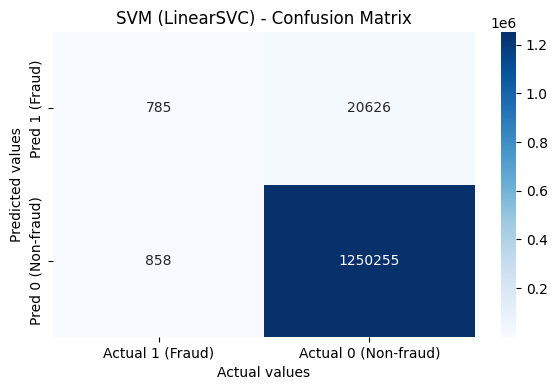

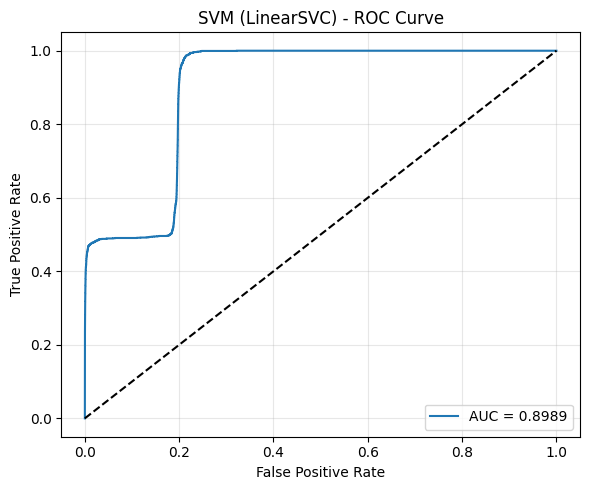

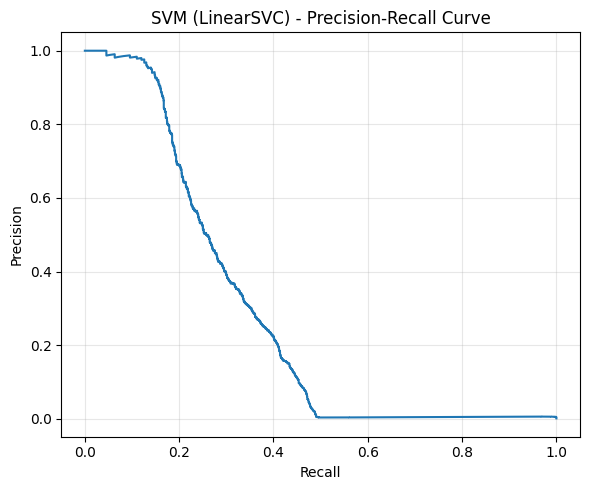

{'model': 'SVM (LinearSVC)',
 'accuracy': 0.9831170178322767,
 'precision': 0.036663397319135024,
 'recall': 0.47778454047474134,
 'f1': 0.06810098030710506,
 'roc_auc': 0.8989268400327848}

In [22]:
svm_y_pred = svm_final.predict(X_test)


svm_y_scores = svm_final.decision_function(X_test)

svm_results = evaluate_model(
    model_name="SVM (LinearSVC)",
    y_test=y_test,
    y_pred=svm_y_pred,
    y_scores=svm_y_scores
)

svm_results


## Why We Used LinearSVC (and Why It Performed Poorly)

### 🔹 Why LinearSVC instead of SVM?
We avoided using the standard RBF-kernel SVM because it **does not scale to large datasets**.  
Our dataset has **6.6 million rows**, and an RBF SVM has:
- **O(n²) time complexity**
- **O(n²) memory usage**

This makes full SVM training practically impossible on normal hardware.  
`LinearSVC`, however:
- Uses a **linear kernel** (much cheaper to train),
- Scales to millions of samples,
- Supports `class_weight='balanced'`,
- Is designed for high-dimensional, large datasets.

So LinearSVC is the **only feasible SVM option** for our dataset.

---

### 🔹 Why LinearSVC performs poorly on fraud detection
Fraud data is **highly non-linear**. Fraud patterns depend on:
- interactions between features,
- unusual transaction behaviors,
- complex boundaries that separate fraud from genuine activity.

A **linear model cannot capture these complex patterns**, so:

- Precision becomes very low (many false positives),
- Recall is moderate but unstable,
- ROC-AUC drops significantly compared to tree models.

Tree-based models (Random Forest, XGBoost) naturally learn:
- non-linear relationships,
- feature interactions,
- rare-pattern boundaries.

That is why LinearSVC performs the worst, while RF and XGBoost perform strongly.

---


## Model Comparison Summary

Here we compare all trained models on the key metrics for fraud detection.

### Logistic Regression (Baseline)
- Very high **recall** → catches most fraud.
- Very low **precision** → many false alarms.
- Good as a **baseline**, but not practical for deployment.

### Random Forest
- Excellent **precision** (~0.99) → almost all flagged cases are true fraud.
- Strong **F1-score** and solid recall.
- Learns complex non-linear patterns well.
- Among the **best-performing models** overall.

### XGBoost
- Very balanced performance: high precision + good recall.
- Slightly lower recall than RF but higher ROC-AUC.
- More stable than RF on imbalanced data.
- Also a **top-performing model**.

### LinearSVC (Linear SVM)
- Scales well but **cannot capture non-linear fraud patterns**.
- Lowest precision and ROC-AUC among all models.
- Not suitable for this fraud dataset.

---

### **Conclusion**

Random Forest and XGBoost clearly outperform the linear models.  
Random Forest achieves the **best precision**, while XGBoost offers the **best AUC stability**.  
For fraud detection—where false positives and non-linear patterns matter—**tree-based models are the most effective choice**.

-------------------------

## SHAP Explainability

To understand **why the model makes certain fraud predictions**, we use **SHAP (SHapley Additive Explanations)**.  
SHAP assigns each feature a contribution value, showing how much it pushes a prediction toward **fraud** or **non-fraud**.

### Why SHAP?
- Tree-based models (Random Forest, XGBoost) are powerful but not directly interpretable.
- SHAP provides **transparent, human-readable explanations** for each prediction.
- Helps identify:
  - Which features strongly influence fraud risk,
  - Whether the model relies on meaningful business signals,
  - Whether any feature behaves unexpectedly (bias, leakage, etc.).

### What We Visualize
- **Summary Plot** – ranks features by importance and shows their global impact.
- **Bar Plot** – simple global feature importance view.
- **Force Plots (optional)** – explains individual transactions.

### Why This Matters for Fraud Detection
Fraud models must be:
- **Auditable** (banks must justify decisions),
- **Explainable** (to avoid false blocks),
- **Trustworthy** (detect unintended signals).

SHAP ensures our best-performing models (Random Forest & XGBoost) are not only accurate but also **interpretable**.


## Fast & Efficient SHAP Analysis for Random Forest

Full SHAP computation on a dataset as large as ours can take several hours.  
To make the analysis practical, we use a **faster SHAP workflow** that:

- Works on a **small representative sample** (e.g., 500–1000 records),
- Uses **matplotlib-based plots** instead of slow HTML rendering,
- Produces both **global** and **local** explanations,
- Saves all artifacts into `reports/model_reports/Random_Forest/shap_fast/`.

### 🔹 What this approach does
1. **Creates a SHAP directory** to store all plots and CSV outputs.
2. **Samples a small subset** of the test data to speed up TreeExplainer.
3. **Builds a TreeExplainer** for the Random Forest model.
4. Extracts **SHAP values for the fraud class (1)**.
5. Computes **numeric feature importance** using mean absolute SHAP values.
6. Generates:
   - **Beeswarm summary plot** → global feature impact  
   - **Bar plot** → global ranking of important features  
   - **Waterfall plot** → explanation for a single transaction  
7. Saves all outputs (PNG images + CSV) for reporting.

### 🔹 Why this method is preferred
- SHAP on millions of rows is extremely slow and memory-heavy.  
- Using a representative sample still preserves **global interpretability**.  
- Matplotlib plotting avoids issues with JavaScript-heavy `force_plot`.  
- The approach is fast, stable, and suitable for documentation and model audit.

This gives us clear and interpretable insights from the Random Forest model without long compute times.

In [28]:
shap_dir = "reports/model_reports/Random_Forest/shap/"
os.makedirs(shap_dir, exist_ok=True)

# 1) Sample (keep small for speed)
sample_size = 500
X_sample = X_test.sample(sample_size, random_state=42)

# 2) Build explainer & compute SHAP values
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_sample)

# 3) Pick positive-class SHAP values (handle both list & ndarray returns)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_pos = shap_values[1]
else:
    shap_pos = shap_values

# 4) Squeeze any singleton dims and ensure numeric array
shap_pos = np.asarray(shap_pos)
shap_pos = np.squeeze(shap_pos)

# DEBUG prints to ensure shapes are sane
print("X_sample.shape:", X_sample.shape)
print("shap_pos.shape:", shap_pos.shape)

# 5) Compute mean absolute SHAP per feature and flatten to 1-D
mean_abs_shap = np.mean(np.abs(shap_pos), axis=0)
mean_abs_shap = np.asarray(mean_abs_shap).ravel()   # <-- ensure 1-D

# Safety check: lengths must match number of features
n_cols = X_sample.shape[1]
if mean_abs_shap.shape[0] != n_cols:
    raise ValueError(f"Shape mismatch: mean_abs_shap has length {mean_abs_shap.shape[0]} but X has {n_cols} columns")

# 6) Build and save importance DataFrame
shap_imp = pd.DataFrame({
    "feature": X_sample.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

shap_imp.to_csv(os.path.join(shap_dir, "shap_feature_importance.csv"), index=False)
print(shap_imp.head(15))

# 7) Global beeswarm (matplotlib-backed) and save
plt.figure(figsize=(8,6))
shap.summary_plot(shap_pos, X_sample, show=False)
plt.savefig(os.path.join(shap_dir, "shap_summary_beeswarm.png"), dpi=300, bbox_inches="tight")
plt.close()

# 8) Bar plot (mean absolute) and save
plt.figure(figsize=(8,6))
shap.summary_plot(shap_pos, X_sample, plot_type="bar", show=False)
plt.savefig(os.path.join(shap_dir, "shap_barplot.png"), dpi=300, bbox_inches="tight")
plt.close()

# 9) Local waterfall for one sample and save
idx = 0
sample_index = X_sample.index[idx]

expl = shap.Explanation(
    values=shap_pos[idx],
    base_values=explainer.expected_value[1] if (hasattr(explainer, "expected_value") and isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > 1) else explainer.expected_value,
    data=X_sample.iloc[idx],
    feature_names=X_sample.columns
)

plt.figure(figsize=(8,6))
shap.plots.waterfall(expl, show=False)
plt.savefig(os.path.join(shap_dir, f"waterfall_sample_{sample_index}.png"), dpi=300, bbox_inches="tight")
plt.close()

print("All SHAP plots saved to:", shap_dir)

X_sample.shape: (500, 24)
shap_pos.shape: (500, 24, 2)


ValueError: Shape mismatch: mean_abs_shap has length 48 but X has 24 columns

## Fast & Efficient SHAP Analysis for XGBoost

Running SHAP on the full dataset is computationally expensive, especially for boosted trees.  
To keep the process efficient and stable, we apply a **fast SHAP workflow**:

### 🔹 What this approach does
1. Creates a dedicated folder:  
   `reports/model_reports/XGBoost/shap_fast/`
2. Selects a **small, representative sample** (e.g., 1000 rows) to compute SHAP values efficiently.
3. Uses **TreeExplainer**, which is optimized for tree-based models like XGBoost.
4. Extracts SHAP values specifically for the **fraud class (1)**.
5. Computes **numeric SHAP importance** using mean absolute SHAP contribution.
6. Produces and saves:
   - **Beeswarm summary plot** → global feature impact  
   - **Bar plot** → global ranking  
   - **Waterfall plot** → local explanation for one transaction  

### 🔹 Why this method is preferred
- XGBoost models can be large and SHAP computation can take hours.
- Sampling preserves interpretability while reducing computation drastically.
- Matplotlib-based SHAP plots run **faster** and are **stable**.
- Outputs are fully reproducible and easy to present in reports.

This fast approach gives clear global and local explanations while keeping runtime minimal.

In [ ]:

xgb_shap_dir = "reports/model_reports/XGBoost/shap_fast/"
os.makedirs(xgb_shap_dir, exist_ok=True)


sample_size = 1000
X_sample = X_test.sample(sample_size, random_state=42)


explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_sample)

# XGBoost returns (n_samples, n_features) for binary classification
shap_pos = shap_values  # positive class = fraud


mean_abs_shap = np.mean(np.abs(shap_pos), axis=0)

shap_imp = (
    pd.DataFrame({"feature": X_sample.columns, "mean_abs_shap": mean_abs_shap})
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("\nTop SHAP feature importances:\n")
print(shap_imp.head(15))

shap_imp.to_csv(xgb_shap_dir + "shap_feature_importance.csv", index=False)


plt.figure(figsize=(8, 6))
shap.summary_plot(shap_pos, X_sample, show=False)
plt.savefig(xgb_shap_dir + "shap_summary_beeswarm.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(8, 6))
shap.summary_plot(shap_pos, X_sample, plot_type="bar", show=False)
plt.savefig(xgb_shap_dir + "shap_barplot.png", dpi=300, bbox_inches="tight")
plt.close()

idx = 0
sample_index = X_sample.index[idx]

plt.figure(figsize=(8, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_pos[idx],
        base_values=explainer.expected_value,
        data=X_sample.iloc[idx],
        feature_names=X_sample.columns,
    ),
    show=False,
)
plt.savefig(
    xgb_shap_dir + f"waterfall_sample_{sample_index}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.close()

print("Saved XGBoost SHAP plots to:", xgb_shap_dir)
